In [9]:
import pandas as pd
import numpy as np
from pycaret.regression import *
from scipy import stats

df = pd.read_csv("data_preprocess/raw_data/dmr_tidal-level-phuket-tidegauge-2013_2023.csv")
# ลบช่องว่างเกินออก (กันกรณีมี space แปลก ๆ)
df["DATE"] = df["DATE"].str.strip()

# เติมเลข 0 ให้ชั่วโมงหลักเดียว และเติม ":00" ถ้าขาดวินาที
df["DATE"] = df["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{1}):(\d{2})$", r"\1 0\2:\3:00", regex=True)
df["DATE"] = df["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{2}:\d{2})$", r"\1 \2:00", regex=True)

# แปลงเป็น datetime โดยกำหนด dayfirst=True
df["DATE"] = pd.to_datetime(df["DATE"], format="%d/%m/%Y %H:%M:%S", dayfirst=True)
df.set_index('DATE', inplace=True)
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df = df.drop(columns=["TW_ID", "TW_NAME", "UTM_E", 'UTM_N'], axis=1)
df = df.resample("h").mean()
df.dropna(inplace=True)

import ephem
# ฟังก์ชันหาข้างขึ้นข้างแรม
def get_moon_phase(dt):
    moon_phase = ephem.Moon(dt).phase  # คำนวณเฟสของดวงจันทร์
    return round(moon_phase)  # ปัดค่า phase ให้เป็นจำนวนเต็ม (0-29)

# คำนวณข้างขึ้นข้างแรม และเพิ่มเป็นคอลัมน์ใหม่
df["moon_phase"] = df.index.to_series().apply(get_moon_phase)

# เพิ่มคอลัมน์ full_moon_days (ขึ้น 15 ค่ำ) และ dark_moon_days (แรม 15 ค่ำ)
df["full_moon_days"] = (df["moon_phase"] == 15).astype(int) #(ขึ้น 15 ค่ำ)
df["dark_moon_days"] = (df["moon_phase"] == 29).astype(int) #(แรม 15 ค่ำ)

df = df[(np.abs(stats.zscore(df['W_LEV_AVG'])) < 3)]  # ลบค่าผิดปกติออก

In [10]:
# Create lag features for the past 14 days
for lag in range(1, 15):  # Lags from 1 to 14 days
    df[f'W_LEV_AVG_lag_{lag}'] = df['W_LEV_AVG'].shift(lag)

# Drop NaN values caused by shifting
df.dropna(inplace=True)

In [12]:
df

,W_LEV_AVG,dayofweek,month,day,hour,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2,W_LEV_AVG_lag_3,W_LEV_AVG_lag_4,W_LEV_AVG_lag_5,W_LEV_AVG_lag_6,W_LEV_AVG_lag_7,W_LEV_AVG_lag_8,W_LEV_AVG_lag_9,W_LEV_AVG_lag_10,W_LEV_AVG_lag_11,W_LEV_AVG_lag_12,W_LEV_AVG_lag_13,W_LEV_AVG_lag_14
DATE,,,,,,,,,,,,,,,,,,,,,,
2013-10-01 21:00:00,0.606317,1.0,10.0,1.0,21.0,11,0,0,0.612350,0.414050,0.085083,-0.329267,-0.719017,-0.985550,-1.078483,-0.944783,-0.619317,-0.198067,0.199967,0.477117,0.577550,0.495833
2013-10-01 22:00:00,0.397000,1.0,10.0,1.0,22.0,10,0,0,0.606317,0.612350,0.414050,0.085083,-0.329267,-0.719017,-0.985550,-1.078483,-0.944783,-0.619317,-0.198067,0.199967,0.477117,0.577550
2013-10-01 23:00:00,0.026983,1.0,10.0,1.0,23.0,10,0,0,0.397000,0.606317,0.612350,0.414050,0.085083,-0.329267,-0.719017,-0.985550,-1.078483,-0.944783,-0.619317,-0.198067,0.199967,0.477117
2013-10-02 00:00:00,-0.425300,2.0,10.0,2.0,0.0,10,0,0,0.026983,0.397000,0.606317,0.612350,0.414050,0.085083,-0.329267,-0.719017,-0.985550,-1.078483,-0.944783,-0.619317,-0.198067,0.199967
2013-10-02 01:00:00,-0.806400,2.0,10.0,2.0,1.0,10,0,0,-0.425300,0.026983,0.397000,0.606317,0.612350,0.414050,0.085083,-0.329267,-0.719017,-0.985550,-1.078483,-0.944783,-0.619317,-0.198067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,-1.144383,6.0,12.0,31.0,19.0,80,0,0,-1.174217,-0.994833,-0.641167,-0.207283,0.138883,0.336617,0.324467,0.111000,-0.283867,-0.760083,-1.194783,-1.447617,-1.488217,-1.237317
2023-12-31 20:00:00,-0.888383,6.0,12.0,31.0,20.0,79,0,0,-1.144383,-1.174217,-0.994833,-0.641167,-0.207283,0.138883,0.336617,0.324467,0.111000,-0.283867,-0.760083,-1.194783,-1.447617,-1.488217
2023-12-31 21:00:00,-0.470750,6.0,12.0,31.0,21.0,79,0,0,-0.888383,-1.144383,-1.174217,-0.994833,-0.641167,-0.207283,0.138883,0.336617,0.324467,0.111000,-0.283867,-0.760083,-1.194783,-1.447617


In [13]:
exp = setup(data=df, target='W_LEV_AVG', fold=10, train_size=0.8, session_id=123, iterative_imputation_iters=100, remove_outliers = True, use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Description,Value
0,Session id,123
1,Target,W_LEV_AVG
2,Target type,Regression
3,Original data shape,"(88470, 22)"
4,Transformed data shape,"(84931, 22)"
5,Transformed train set shape,"(67237, 22)"
6,Transformed test set shape,"(17694, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [15]:
best_model = exp.compare_models()  # Find the best regression model

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0264,0.0021,0.0452,0.9964,0.0276,0.2368,0.8040
ridge,Ridge Regression,0.0267,0.0021,0.0452,0.9964,0.0277,0.2392,0.7970
br,Bayesian Ridge,0.0264,0.0021,0.0452,0.9964,0.0276,0.2368,0.8020
et,Extra Trees Regressor,0.0313,0.0022,0.0464,0.9963,0.0288,0.2965,5.2910
rf,Random Forest Regressor,0.0336,0.0025,0.0498,0.9958,0.0309,0.2988,14.7130
lightgbm,Light Gradient Boosting Machine,0.0360,0.0028,0.0527,0.9953,0.0326,0.2883,2.3010
dt,Decision Tree Regressor,0.0540,0.0057,0.0757,0.9903,0.0472,0.4410,2.0720
par,Passive Aggressive Regressor,0.0619,0.0065,0.0795,0.9891,0.0511,0.5869,0.8910
gbr,Gradient Boosting Regressor,0.0621,0.0066,0.0813,0.9888,0.0511,0.6307,31.9850
huber,Huber Regressor,0.0634,0.0071,0.0841,0.9880,0.0543,0.5730,2.0720


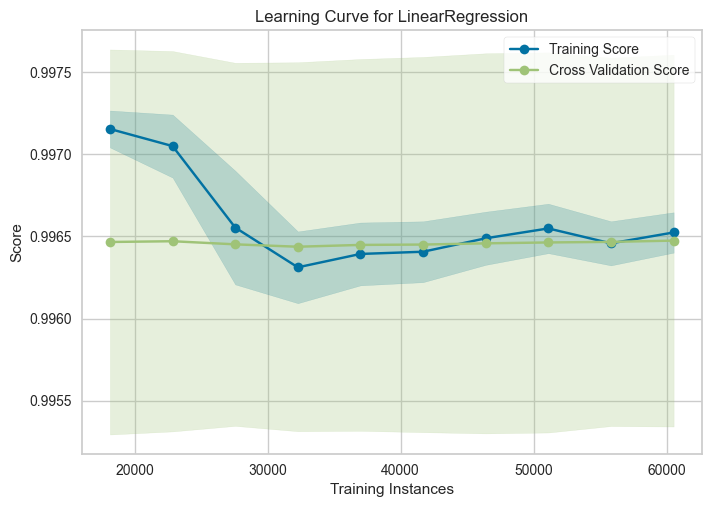

In [16]:
plot_model(best_model, plot='learning')

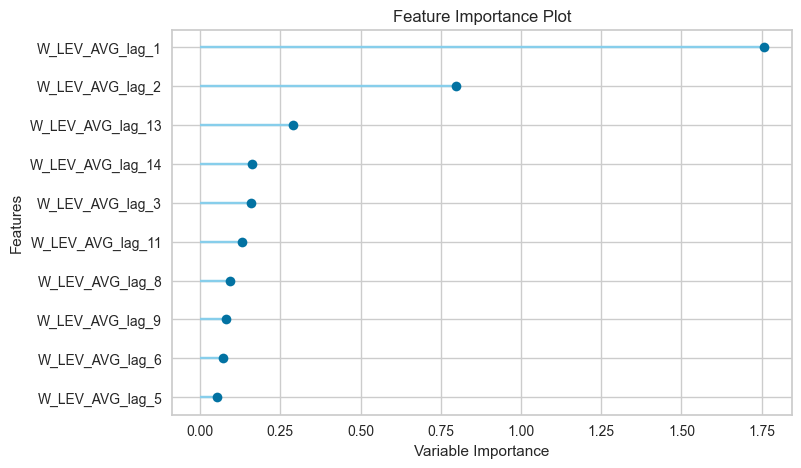

In [17]:
plot_model(best_model, plot='feature')

In [20]:
prediction = exp.predict_model(best_model, data=df)
prediction

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0265,0.0021,0.0460,0.9964,0.0281,0.2234


,dayofweek,month,day,hour,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2,W_LEV_AVG_lag_3,...,W_LEV_AVG_lag_7,W_LEV_AVG_lag_8,W_LEV_AVG_lag_9,W_LEV_AVG_lag_10,W_LEV_AVG_lag_11,W_LEV_AVG_lag_12,W_LEV_AVG_lag_13,W_LEV_AVG_lag_14,W_LEV_AVG,prediction_label
DATE,,,,,,,,,,,,,,,,,,,,,
2013-10-01 21:00:00,1.0,10.0,1.0,21.0,11,0,0,0.612350,0.414050,0.085083,...,-1.078483,-0.944783,-0.619317,-0.198067,0.199967,0.477117,0.577550,0.495833,0.606317,0.610517
2013-10-01 22:00:00,1.0,10.0,1.0,22.0,10,0,0,0.606317,0.612350,0.414050,...,-0.985550,-1.078483,-0.944783,-0.619317,-0.198067,0.199967,0.477117,0.577550,0.397000,0.401063
2013-10-01 23:00:00,1.0,10.0,1.0,23.0,10,0,0,0.397000,0.606317,0.612350,...,-0.719017,-0.985550,-1.078483,-0.944783,-0.619317,-0.198067,0.199967,0.477117,0.026983,0.036944
2013-10-02 00:00:00,2.0,10.0,2.0,0.0,10,0,0,0.026983,0.397000,0.606317,...,-0.329267,-0.719017,-0.985550,-1.078483,-0.944783,-0.619317,-0.198067,0.199967,-0.425300,-0.399153
2013-10-02 01:00:00,2.0,10.0,2.0,1.0,10,0,0,-0.425300,0.026983,0.397000,...,0.085083,-0.329267,-0.719017,-0.985550,-1.078483,-0.944783,-0.619317,-0.198067,-0.806400,-0.815039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,6.0,12.0,31.0,19.0,80,0,0,-1.174217,-0.994833,-0.641167,...,0.324467,0.111000,-0.283867,-0.760083,-1.194783,-1.447617,-1.488217,-1.237317,-1.144383,-1.139250
2023-12-31 20:00:00,6.0,12.0,31.0,20.0,79,0,0,-1.144383,-1.174217,-0.994833,...,0.336617,0.324467,0.111000,-0.283867,-0.760083,-1.194783,-1.447617,-1.488217,-0.888383,-0.901066
2023-12-31 21:00:00,6.0,12.0,31.0,21.0,79,0,0,-0.888383,-1.144383,-1.174217,...,0.138883,0.336617,0.324467,0.111000,-0.283867,-0.760083,-1.194783,-1.447617,-0.470750,-0.474547


In [24]:
import pandas as pd
import numpy as np
from pycaret.regression import *
# W_LEV_AVG	= ค่าระดับน้ำทะเล หน่วยเมตร
# Load your dataset
df_test = pd.read_csv("data_preprocess/raw_data/dmr_tidal-level-chompon-tidegauge-2016_2023.csv")
# ลบช่องว่างเกินออก (กันกรณีมี space แปลก ๆ)
df_test["DATE"] = df_test["DATE"].str.strip()

# เติมเลข 0 ให้ชั่วโมงหลักเดียว และเติม ":00" ถ้าขาดวินาที
df_test["DATE"] = df_test["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{1}):(\d{2})$", r"\1 0\2:\3:00", regex=True)
df_test["DATE"] = df_test["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{2}:\d{2})$", r"\1 \2:00", regex=True)

# แปลงเป็น datetime โดยกำหนด dayfirst=True
df_test["DATE"] = pd.to_datetime(df_test["DATE"], format="%d/%m/%Y %H:%M:%S", dayfirst=True)
df_test.set_index('DATE', inplace=True)
df_test['dayofweek'] = df_test.index.dayofweek
df_test['month'] = df_test.index.month
df_test['day'] = df_test.index.day
df_test['hour'] = df_test.index.hour
df_test = df_test.drop(columns=["TW_ID", "TW_NAME", "UTM_E", 'UTM_N'], axis=1)
df_test_h = df_test.resample("h").mean()
df_test_h.dropna(inplace=True)
df_test_h

,W_LEV_AVG,dayofweek,month,day,hour
DATE,,,,,
2016-07-22 07:00:00,-0.808667,4.0,7.0,22.0,7.0
2016-07-22 08:00:00,-0.884400,4.0,7.0,22.0,8.0
2016-07-22 09:00:00,-0.896167,4.0,7.0,22.0,9.0
2016-07-22 10:00:00,-0.871017,4.0,7.0,22.0,10.0
2016-07-22 11:00:00,-0.823017,4.0,7.0,22.0,11.0
...,...,...,...,...,...
2023-12-31 19:00:00,0.036850,6.0,12.0,31.0,19.0
2023-12-31 20:00:00,-0.141900,6.0,12.0,31.0,20.0
2023-12-31 21:00:00,-0.272483,6.0,12.0,31.0,21.0


In [25]:
# ฟังก์ชันหาข้างขึ้นข้างแรม
def get_moon_phase(dt):
    moon_phase = ephem.Moon(dt).phase  # คำนวณเฟสของดวงจันทร์
    return round(moon_phase)  # ปัดค่า phase ให้เป็นจำนวนเต็ม (0-29)

# คำนวณข้างขึ้นข้างแรม และเพิ่มเป็นคอลัมน์ใหม่
df_test_h["moon_phase"] = df_test_h.index.to_series().apply(get_moon_phase)

# เพิ่มคอลัมน์ full_moon_days (ขึ้น 15 ค่ำ) และ dark_moon_days (แรม 15 ค่ำ)
df_test_h["full_moon_days"] = (df_test_h["moon_phase"] == 15).astype(int) #(ขึ้น 15 ค่ำ)
df_test_h["dark_moon_days"] = (df_test_h["moon_phase"] == 29).astype(int) #(แรม 15 ค่ำ)

In [26]:
# Create lag features for the past 14 days
for lag in range(1, 15):  # Lags from 1 to 14 days
    df_test_h[f'W_LEV_AVG_lag_{lag}'] = df_test_h['W_LEV_AVG'].shift(lag)

# Drop NaN values caused by shifting
df_test_h.dropna(inplace=True)
df_test_h

,W_LEV_AVG,dayofweek,month,day,hour,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2,...,W_LEV_AVG_lag_5,W_LEV_AVG_lag_6,W_LEV_AVG_lag_7,W_LEV_AVG_lag_8,W_LEV_AVG_lag_9,W_LEV_AVG_lag_10,W_LEV_AVG_lag_11,W_LEV_AVG_lag_12,W_LEV_AVG_lag_13,W_LEV_AVG_lag_14
DATE,,,,,,,,,,,,,,,,,,,,,
2016-07-22 21:00:00,0.214950,4.0,7.0,22.0,21.0,90,0,0,-0.016017,-0.196950,...,-0.506700,-0.571750,-0.638933,-0.717783,-0.792517,-0.823017,-0.871017,-0.896167,-0.884400,-0.808667
2016-07-22 22:00:00,0.420167,4.0,7.0,22.0,22.0,90,0,0,0.214950,-0.016017,...,-0.425967,-0.506700,-0.571750,-0.638933,-0.717783,-0.792517,-0.823017,-0.871017,-0.896167,-0.884400
2016-07-22 23:00:00,0.584150,4.0,7.0,22.0,23.0,90,0,0,0.420167,0.214950,...,-0.328733,-0.425967,-0.506700,-0.571750,-0.638933,-0.717783,-0.792517,-0.823017,-0.871017,-0.896167
2016-07-23 00:00:00,0.697883,5.0,7.0,23.0,0.0,89,0,0,0.584150,0.420167,...,-0.196950,-0.328733,-0.425967,-0.506700,-0.571750,-0.638933,-0.717783,-0.792517,-0.823017,-0.871017
2016-07-23 01:00:00,0.637950,5.0,7.0,23.0,1.0,89,0,0,0.697883,0.584150,...,-0.016017,-0.196950,-0.328733,-0.425967,-0.506700,-0.571750,-0.638933,-0.717783,-0.792517,-0.823017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,0.036850,6.0,12.0,31.0,19.0,80,0,0,0.256650,0.498333,...,1.157567,1.265883,1.234800,1.094383,0.889250,0.642400,0.408083,0.209600,0.064233,-0.052000
2023-12-31 20:00:00,-0.141900,6.0,12.0,31.0,20.0,79,0,0,0.036850,0.256650,...,0.984217,1.157567,1.265883,1.234800,1.094383,0.889250,0.642400,0.408083,0.209600,0.064233
2023-12-31 21:00:00,-0.272483,6.0,12.0,31.0,21.0,79,0,0,-0.141900,0.036850,...,0.759050,0.984217,1.157567,1.265883,1.234800,1.094383,0.889250,0.642400,0.408083,0.209600


In [28]:
test_pred = predict_model(best_model, data=df_test_h)
test_pred

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0495,0.0044,0.0664,0.9818,0.0456,0.7148


,dayofweek,month,day,hour,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2,W_LEV_AVG_lag_3,...,W_LEV_AVG_lag_7,W_LEV_AVG_lag_8,W_LEV_AVG_lag_9,W_LEV_AVG_lag_10,W_LEV_AVG_lag_11,W_LEV_AVG_lag_12,W_LEV_AVG_lag_13,W_LEV_AVG_lag_14,W_LEV_AVG,prediction_label
DATE,,,,,,,,,,,,,,,,,,,,,
2016-07-22 21:00:00,4.0,7.0,22.0,21.0,90,0,0,-0.016017,-0.196950,-0.328733,...,-0.638933,-0.717783,-0.792517,-0.823017,-0.871017,-0.896167,-0.884400,-0.808667,0.214950,0.101672
2016-07-22 22:00:00,4.0,7.0,22.0,22.0,90,0,0,0.214950,-0.016017,-0.196950,...,-0.571750,-0.638933,-0.717783,-0.792517,-0.823017,-0.871017,-0.896167,-0.884400,0.420167,0.348893
2016-07-22 23:00:00,4.0,7.0,22.0,23.0,90,0,0,0.420167,0.214950,-0.016017,...,-0.506700,-0.571750,-0.638933,-0.717783,-0.792517,-0.823017,-0.871017,-0.896167,0.584150,0.507032
2016-07-23 00:00:00,5.0,7.0,23.0,0.0,89,0,0,0.584150,0.420167,0.214950,...,-0.425967,-0.506700,-0.571750,-0.638933,-0.717783,-0.792517,-0.823017,-0.871017,0.697883,0.612672
2016-07-23 01:00:00,5.0,7.0,23.0,1.0,89,0,0,0.697883,0.584150,0.420167,...,-0.328733,-0.425967,-0.506700,-0.571750,-0.638933,-0.717783,-0.792517,-0.823017,0.637950,0.681459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,6.0,12.0,31.0,19.0,80,0,0,0.256650,0.498333,0.759050,...,1.234800,1.094383,0.889250,0.642400,0.408083,0.209600,0.064233,-0.052000,0.036850,0.085477
2023-12-31 20:00:00,6.0,12.0,31.0,20.0,79,0,0,0.036850,0.256650,0.498333,...,1.265883,1.234800,1.094383,0.889250,0.642400,0.408083,0.209600,0.064233,-0.141900,-0.072855
2023-12-31 21:00:00,6.0,12.0,31.0,21.0,79,0,0,-0.141900,0.036850,0.256650,...,1.157567,1.265883,1.234800,1.094383,0.889250,0.642400,0.408083,0.209600,-0.272483,-0.188869
